In [1]:
import sys
!{sys.executable} -m pip install trino numpy pandas matplotlib scikit-learn tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 267.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 76.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 273.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 220.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 197.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 307.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 304.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 179.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 292.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 301.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 303.5 MB/

In [2]:
import trino
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

2023-09-15 15:39:36.458910: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-15 15:39:36.507248: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-15 15:39:36.508059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 15:39:37.382037: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
host = 'starburst-starburst.apps.bigdata15.gayv.p1.openshiftapps.com'
port = 80

In [4]:
conn = trino.dbapi.connect(
        host,
        port,
        http_scheme='http',
        user='admin'
        )

In [5]:
cur = conn.cursor()
cur.execute('SELECT * FROM s3.default.msft')
rows = cur.fetchall()

msft = pd.DataFrame(rows)
msft.columns = ['tradedate', 'close', 'volume', 'open', 'high', 'low']
msft



,tradedate,close,volume,open,high,low
0,2018-08-30,111.95,22759640,111.67,112.61,111.44
1,2018-08-31,112.33,23217310,111.69,112.78,111.52
2,2018-09-04,111.71,22558040,110.85,111.96,110.22
3,2018-09-05,108.49,32838650,111.01,111.42,108.10
4,2018-09-06,108.74,23226430,108.25,108.99,107.51
...,...,...,...,...,...,...
1252,2023-08-23,327.00,21166380,323.82,329.20,323.46
1253,2023-08-24,319.97,23281430,332.85,332.98,319.96
1254,2023-08-25,322.98,21684100,321.47,325.36,318.80
1255,2023-08-28,323.70,14808480,325.66,326.15,321.72


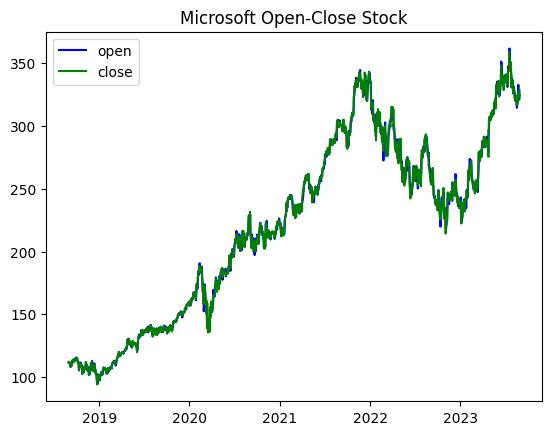

In [6]:
plt.plot(msft['tradedate'],msft['open'],color="blue",label="open")
plt.plot(msft['tradedate'],msft['close'],color="green", label="close")
plt.title("Microsoft Open-Close Stock")
plt.legend()

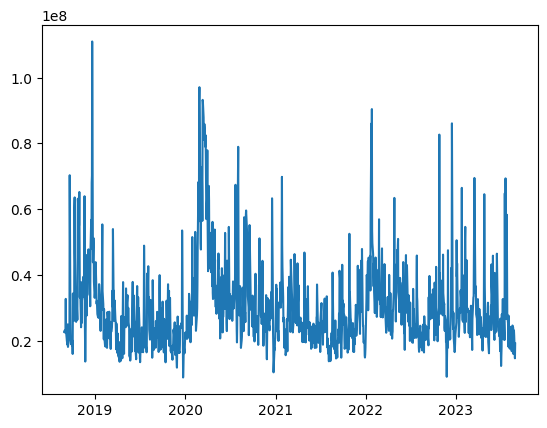

In [7]:
plt.plot(msft['tradedate'],msft['volume'])
plt.show()

In [8]:
close_data = msft.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

1195


In [9]:

 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
 
train_data = scaled_data[0:int(training), :]

# prepare feature and labels
x_train = []
y_train = []
 
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7fb62f05f4f0>>

In [11]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10
36/36 [==============================] - 5s 60ms/step - loss: 0.0449
Epoch 2/10
36/36 [==============================] - 2s 60ms/step - loss: 0.0135
Epoch 3/10
36/36 [==============================] - 2s 59ms/step - loss: 0.0115
Epoch 4/10
36/36 [==============================] - 2s 58ms/step - loss: 0.0102
Epoch 5/10
36/36 [==============================] - 2s 57ms/step - loss: 0.0101
Epoch 6/10
36/36 [==============================] - 2s 58ms/step - loss: 0.0093
Epoch 7/10
36/36 [==============================] - 2s 58ms/step - loss: 0.0103
Epoch 8/10
36/36 [==============================] - 2s 58ms/step - loss: 0.0091
Epoch 9/10
36/36 [==============================] - 2s 58ms/step - loss: 0.0080
Epoch 10/10
36/36 [==============================] - 2s 60ms/step - loss: 0.0077


In [12]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
 
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
 
# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
 
# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2/2 [==============================] - 1s 13ms/step
MSE 104.95807784080088
RMSE 10.244904969827727


/tmp/ipykernel_114/433301594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


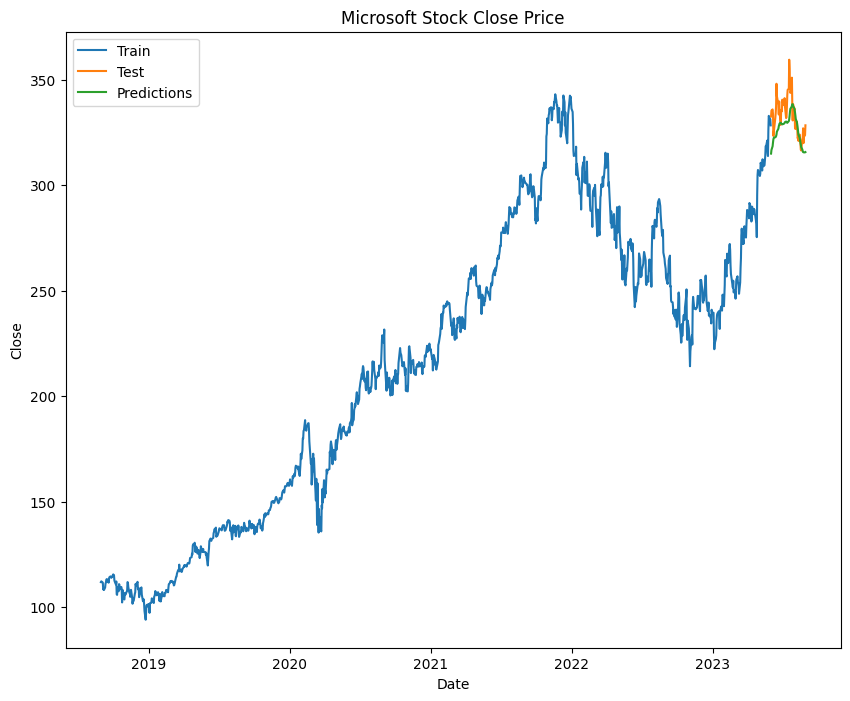

In [14]:
train = msft[:training]
test = msft[training:]
test['Predictions'] = predictions
 
plt.figure(figsize=(10, 8))
plt.plot(train['tradedate'], train['close'])
plt.plot(test['tradedate'], test[['close', 'Predictions']])
plt.title('Microsoft Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])